In [17]:
import jax
import jax.numpy as jnp
from jax import jit
import numpy as np
import optax
import flax
import flax.linen as nn
import flax.training
import flax.training.checkpoints
from ml_collections import ConfigDict
from icecream import ic
import yaml
from pathlib import Path
import os
from jax import random
from jax.example_libraries import stax
import optax
import wandb
from environment_base.wrappers import AutoResetEnvWrapper

from models import Discriminator

In [18]:
X = jnp.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Y = jnp.array([[0, 1, 0], [0, 0, 1], [1, 0, 0]])

config = yaml.safe_load(Path(os.path.join('config', 'lunar_1h_s3.yml')).read_text())
config = ConfigDict(config)

dummy_embedding = jnp.zeros((1, config.embedding_size))

discrim = Discriminator(
    skill_size=config.skill_size,
    hidden1_size=config.discrim_units,
    hidden2_size=config.discrim_units
)
discrim_params = discrim.init(jax.random.PRNGKey(42), dummy_embedding)
discrim_opt = optax.adam(learning_rate=config.discrim_lr)
discrim_opt_state = discrim_opt.init(discrim_params)

In [19]:
@jit
def update_discrim(discrim_params, discrim_opt_state, batch):
    def loss_fn(discrim_params, batch):
        next_obs_embeddings, skills = batch['next_obs_embedding'], batch['skill']

        skill_idxs = jnp.argmax(skills, axis=1)
        skill_preds = discrim.apply(discrim_params, next_obs_embeddings)
        skill_pred_idxs = jnp.argmax(skill_preds, axis=1)
        
        skill_counts = jnp.sum(skills, axis=0, dtype=jnp.int32)
        skill_freqs = skill_counts / skill_counts.sum()
        skill_weights = jnp.where(
            skill_freqs == 0,
            0.0,
            jnp.reciprocal(skill_freqs)
        )[skill_idxs]

        loss = (optax.softmax_cross_entropy(skill_preds, skills) * skill_weights).mean()
        acc = (skill_pred_idxs == skill_idxs).mean()
        pplx = 2. ** jax.scipy.special.entr(nn.activation.softmax(skill_preds)).sum(axis=1).mean()
        discrim_skills_ent = jax.scipy.special.entr(skill_freqs).mean()

        return loss, (acc, pplx, discrim_skills_ent)
    
    (loss, aux_metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(discrim_params, batch)
    updates, discrim_opt_state = discrim_opt.update(grads, discrim_opt_state)
    discrim_params = optax.apply_updates(discrim_params, updates)

    acc, pplx, discrim_skills_ent = aux_metrics
    discrim_metrics = {
        'discrim_loss': loss,
        'discrim_acc': acc,
        'discrim_pplx': pplx,
        'discrim_skills_ent': discrim_skills_ent
    }

    return discrim_params, discrim_opt_state, discrim_metrics    

In [20]:
from tqdm import tqdm

batch = {
    'next_obs_embedding': X,
    'skill': Y
}

for i in tqdm(range(1000)):
    discrim_params, discrim_opt_state, discrim_metrics = update_discrim(discrim_params, discrim_opt_state, batch)
    print(discrim_metrics['discrim_loss'])

 51%|█████▏    | 513/1000 [00:00<00:00, 1380.58it/s]

3.5517077
2.8404117
2.254808
1.7784681
1.3915408
1.0910535
0.85580987
0.67433614
0.5332932
0.42189682
0.334741
0.26622033
0.21338597
0.17174986
0.13905329
0.11316439
0.09270416
0.07650648
0.063673615
0.053345107
0.04500927
0.0383342
0.032882407
0.028408177
0.024709811
0.021650199
0.019109882
0.016995681
0.015218832
0.013708323
0.012422476
0.011324573
0.010379089
0.009561355
0.008850928
0.008231011
0.007690493
0.007215985
0.006805494
0.0064371685
0.006108049
0.005812082
0.0055471375
0.00531096
0.005097849
0.0049039987
0.0047278684
0.004566961
0.0044193747
0.004284041
0.004159414
0.004044543
0.0039379997
0.0038393098
0.0037472835
0.003661445
0.0035814382
0.0035046437
0.003431419
0.003361526
0.0032950845
0.0032317373
0.0031723182
0.0031153988
0.0030610978
0.0030091773
0.002959638
0.0029118839
0.0028663918
0.0028224466
0.0027800498
0.0027383664
0.002697873
0.002658213
0.002619743
0.002582702
0.0025466136
0.0025113584
0.0024774126
0.002444062
0.0024113068
0.0023797425
0.0023490114
0.0023189

100%|██████████| 1000/1000 [00:00<00:00, 1463.95it/s]

0.00010823904
0.00010788144
0.00010728542
0.000106927815
0.0001063318
0.00010597419
0.00010549738
0.000105020576
0.00010454375
0.00010406694
0.00010370933
0.00010323251
0.0001028749
0.000102398095
0.00010192129
0.00010144447
0.00010096766
0.00010061005
0.00010013324
9.977563e-05
9.917961e-05
9.89412e-05
9.8583594e-05
9.798758e-05
9.762996e-05
9.727236e-05
9.679554e-05
9.643793e-05
9.596111e-05
9.560351e-05
9.5365096e-05
9.488829e-05
9.453068e-05
9.429227e-05
9.381546e-05
9.345784e-05
9.321944e-05
9.274263e-05
9.238502e-05
9.20274e-05
9.1550595e-05
9.1192975e-05
9.0835354e-05
9.035854e-05
9.000094e-05
8.976253e-05
8.9404915e-05
8.90473e-05
8.8689696e-05
8.845128e-05
8.797447e-05
8.773606e-05
8.737845e-05
8.702083e-05
8.6663225e-05
8.6424814e-05
8.606721e-05
8.559039e-05
8.523278e-05
8.4994375e-05
8.4875166e-05
8.439834e-05
8.404074e-05
8.3802326e-05
8.344472e-05
8.30871e-05
8.272949e-05
8.2610284e-05
8.225268e-05
8.189506e-05
8.1656646e-05
8.129904e-05
8.094142e-05
8.0703016e-05
8.03454

In [7]:
import flax.training.checkpoints
import os
flax.training.checkpoints.restore_checkpoint(os.path.join(os.getcwd(), 'data', 'perfect_discrim'), target=None)['discrim_params']

{'params': {'Dense_0': {'bias': array([ 5.80285816e-03, -1.75340958e-02,  3.84516940e-02, -1.54775251e-02,
          -9.63828061e-03, -1.00480942e-02,  2.27838885e-02,  3.48260277e-03,
           4.56357822e-02,  2.38657314e-02, -6.84354361e-03,  3.34852077e-02,
           1.15839951e-02,  0.00000000e+00,  3.62151442e-03,  3.84200434e-03,
           3.31777856e-02,  0.00000000e+00,  2.18261257e-02,  2.59017851e-02,
           2.80280001e-02,  0.00000000e+00,  3.53756584e-02,  4.02615732e-03,
           2.46837288e-02,  4.51600552e-02,  3.62382941e-02,  3.50961834e-02,
          -6.43867627e-03,  7.93873332e-03,  2.82745101e-02, -1.74910128e-02,
           0.00000000e+00,  1.02407914e-02,  2.25074273e-02, -2.07328890e-03,
           0.00000000e+00,  0.00000000e+00,  6.32144604e-03,  3.42435129e-02,
          -1.62307974e-02,  2.90451422e-02,  4.19242084e-02,  0.00000000e+00,
           2.69316323e-02,  2.76489221e-02,  2.46628001e-02,  2.90751513e-02,
          -6.98851980e-03, -3.29305

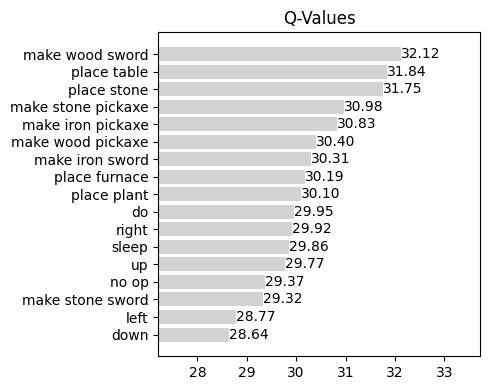

In [7]:
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax

action_names = ['no op', 'left', 'right', 'up', 'down', 'do', 'sleep', 'place stone', 'place table',
                'place furnace', 'place plant', 'make wood pickaxe', 'make stone pickaxe',
                'make iron pickaxe', 'make wood sword', 'make stone sword', 'make iron sword']
values = jax.random.normal(jax.random.PRNGKey(42), (17,)) + 30
tuples = list(zip(action_names, values.tolist()))

tuples.sort(key=lambda x: x[1])

sorted_action_names = [x[0] for x in tuples]
sorted_action_values = [x[1] for x in tuples]

fig, ax = plt.subplots()
fig.set_size_inches(5, 4)
bars = ax.barh(sorted_action_names, sorted_action_values, color='lightgrey')
ax.bar_label(bars, fmt='{:.2f}', label_type='edge', color='black')
ax.set_title('Q-Values')
ax.set_xlim(min(sorted_action_values) * 0.95, max(sorted_action_values) * 1.05)
fig.tight_layout()

In [1]:
import jax

jax.devices()

[cuda(id=0),
 cuda(id=1),
 cuda(id=2),
 cuda(id=3),
 cuda(id=4),
 cuda(id=5),
 cuda(id=6),
 cuda(id=7)]

In [2]:
A = jax.random.normal(jax.random.PRNGKey(42), (17, 30))
B = jax.random.normal(jax.random.PRNGKey(42), (30, 10))

In [3]:
%timeit A @ B

43.4 µs ± 684 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
# 40.4 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
# 6.14 µs ± 60 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)